<h1> Project on  Time Series Analysis: Building a forecast model to predict the furniture sales of a certain store
</h1>
<p> Instructor : Mr. Shriraman Rajagopalan <br>By: Kalyan Chatterjee<p>

<h3/><font color="green">Aim of The Project:<font></h3>
<p>We are provided with a dataset with sales of all the products from 01/2014 to 12/2017. We need to check the stationarity of the Sales data and create a model that can forecast the sales in the coming months. The idea behind this is to find out the popularity of Furnitures and how its sales can impact the business.

In [1]:
import matplotlib.pyplot as plt             # to visualize
from tabulate import tabulate               # to print the table
import matplotlib as mat                    # to visualize 
import seaborn as sns                       # to visualize
import pandas as pd                         # for data reading
import numpy as np  
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import calendar
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import ExponentialSmoothing

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

<h3> Importing Dataset

In [2]:
df = pd.read_excel("DS3_C6_S4_TimeSeries_Sales_Data_Project.xls",parse_dates=True)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
3,742,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
4,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


In [3]:
df.shape

(9994, 21)

In [4]:
df.keys()

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
df.Category.value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

# Furniture Data

In [6]:
df_fur = df[df.Category=="Furniture"]
df_fur.shape

(2121, 21)

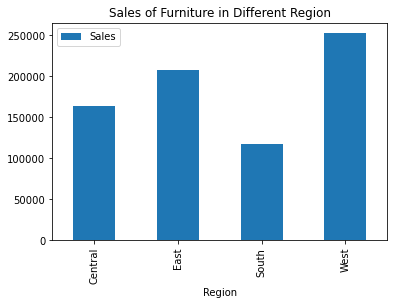

In [7]:
pd.pivot_table(data=df_fur,index="Region",values="Sales",aggfunc="sum").plot(kind="bar")

plt.title("Sales of Furniture in Different Region")
plt.show()

In [8]:
df_fur_new=df_fur.groupby("Order Date").sum("Sales")
df_fur_new = df_fur_new.loc[:,["Sales","Quantity","Discount"]]
df_fur_new= pd.DataFrame(df_fur_new)

In [9]:
day=[]
for i in range (len(df_fur_new)):
        day.append(calendar.day_name[df_fur_new.index[i].weekday()])

In [10]:
df_fur_new["Day"]= day
df_fur_new.head()

,Sales,Quantity,Discount,Day
Order Date,,,,
2014-01-06,2573.820,9,0.00,Monday
2014-01-07,76.728,3,0.60,Tuesday
2014-01-10,51.940,1,0.00,Friday
2014-01-11,9.940,2,0.00,Saturday
2014-01-13,879.939,9,0.15,Monday


In [11]:
df_fur_new.head(14).groupby("Day").sum()

,Sales,Quantity,Discount
Day,,,
Friday,342.606,3,0.15
Monday,5200.269,36,0.35
Saturday,24.500,4,0.00
Sunday,398.670,13,0.70
Thursday,127.104,6,0.20
Tuesday,163.936,10,1.30


<h6>As we can see that the the Total Sales of Furniture in a store is high during each Monday so there is a weekly seasonality present in the dataset

In [12]:
df_fur_new=df_fur.groupby("Order Date").sum("Sales")
df_fur_new= df_fur_new.asfreq("m",fill_value=0)
df_fur_new.drop(["Row ID","Postal Code"],axis=1,inplace=True)

In [13]:
df_fur_new.shape

(47, 4)

In [14]:
df_fur_new.head()

,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-31,290.666,2,0.15,3.4196
2014-02-28,0.000,0,0.00,0.0000
2014-03-31,1125.488,7,0.20,98.4802
2014-04-30,0.000,0,0.00,0.0000
2014-05-31,0.000,0,0.00,0.0000


In [15]:
df1_decomposed_Sales= sm.tsa.seasonal_decompose(df_fur_new.Sales,period=12,model='additive') 

<h3> <font color="green">Decomposition of the Data

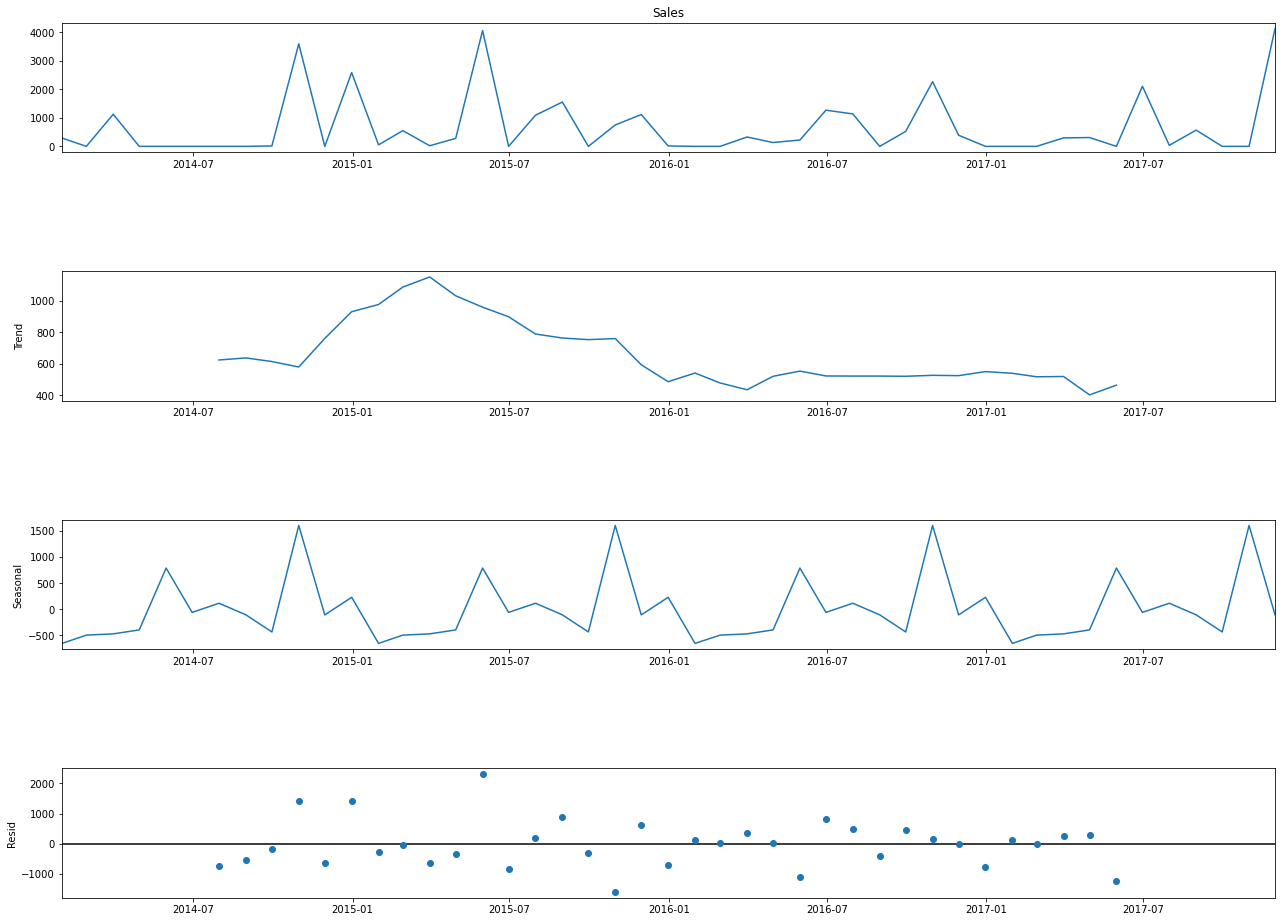

In [16]:
fig= df1_decomposed_Sales.plot()
fig.set_size_inches((20,15))
plt.show()

<h3/>In the above plot we can see that:</h3>

    1. Trend: Very less decreasing tred can be noticed in the dataset.
    2. Seasonality: At the end of each year there is a peak of Sales can be observed.

<h3/><font color="green">Checking Stationarity: </h3>
    <p/>In order to apply a time series model, it is important for the Time series to be stationary.in other words all its statistical properties (mean,variance) remain constant over time. </p><br>
    A data is stationary if it has:
      <li/> Constant mean </li>
     <li/>  Constant variance </li>
     <li/>  Constant co-variance  </li>

<h6>Rolling Mean : Graphical Technique to check Stationarity

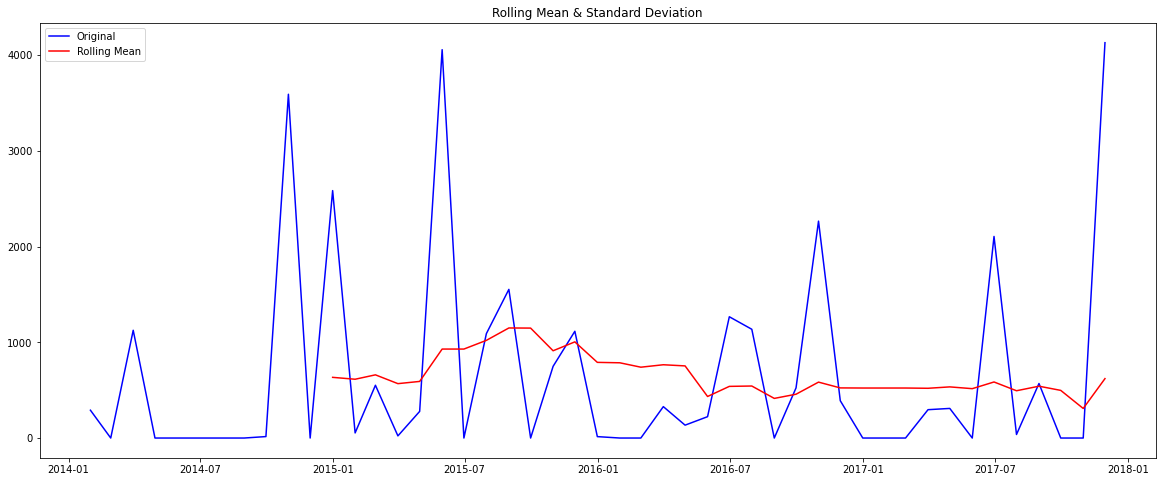

In [17]:
#Determing rolling statistics
rolmean = pd.Series(df_fur_new.Sales).rolling(window=12).mean()


#Plot rolling Mean:
plt.figure(figsize=(20,8))
plt.plot(df_fur_new.Sales, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

<h6>We can see in the above Rolling Mean plot that Rolling Mean is Constant through out the time.<br>
We can consider the dataset as stationary <br>
For further confirmation lets apply Dicky-Fuller Test

<h6>Dickey-Fuller test: Statistical approach to Find Stationarity

In [18]:
def df_test(Series):
    print('Dickey-Fuller Test:')
    print("="*100)
    test = adfuller(Series, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)
    
    pvalue= output[1]
    
    print()
    if pvalue < 0.05:
        msg = "pvalue={}.\nData is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}.\nData is not Stationary. Make the data stationary before model building".format(pvalue)

    print( msg)


In [19]:
df_test(df_fur_new.Sales)

Dickey-Fuller Test:
Test Statistic                -7.360436e+00
p-value                        9.531939e-11
#Lags Used                     0.000000e+00
Number of Observations Used    4.600000e+01
dtype: float64

pvalue=9.53193946866187e-11.
Data is Stationary. Proceed to model building


<h6> Dicky-Fuller test confirms that the given data is Stationary. So we can proceed directly with model building

<h3/><font color= "green"> Smoothing the Time Series Data: </h3> As the time series contains both trend and stationarity therefore we will use Tripple Exponential Smoothing Technique

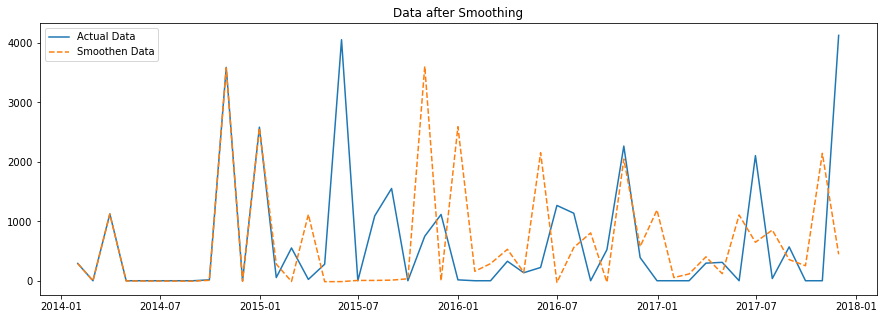

In [20]:
model_smooth = ExponentialSmoothing(df_fur_new.Sales,trend='add',seasonal='add',seasonal_periods=12).fit()
df_smooth= model_smooth.fittedvalues

plt.figure(figsize=(15,5))
plt.plot(df_fur_new.Sales,label= "Actual Data")
plt.plot(df_smooth,"--" ,label="Smoothen Data")
plt.legend()
plt.title("Data after Smoothing")
plt.show()

<h3>Splitting in test Train data

In [21]:
len_train= int(len(df_smooth)*0.8)
df_fur_train = df_smooth[:len_train]
df_fur_test = df_smooth[len_train:]
print("Length of Test Set", len(df_fur_train))
print("Length of Test Set", len(df_fur_test))

Length of Test Set 37
Length of Test Set 10


In [22]:
train= df_fur_new[:len_train]
test= df_fur_new[len_train:]

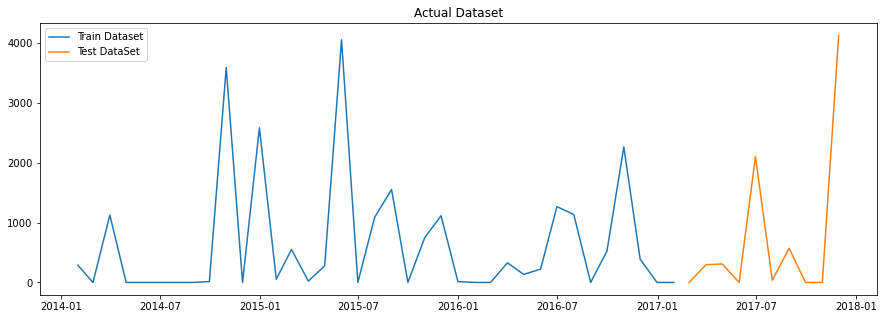

In [23]:
plt.figure(figsize=(15,5))
plt.plot(train.Sales,label= "Train Dataset")
plt.plot(test.Sales, label="Test DataSet")
plt.legend()
plt.title("Actual Dataset")
plt.show()

<h6>Creating Function for Evaluating a Model

In [24]:
def timeseries_evaluation_metrics(y_true, y_pred):
    
    print('Evaluation metric results:-')
    print("="*100)
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

<h3>Persistance Model / Naive Forecast

In [25]:
df= pd.DataFrame(df_smooth,columns=["Sales"])
df['lag1'] =  df.shift(12)

In [26]:
len_train= int(len(df)*0.8)
df_train = df.Sales[:len_train]
df_test = df.Sales[len_train:]
df_predicted_test= df.lag1[len_train:]

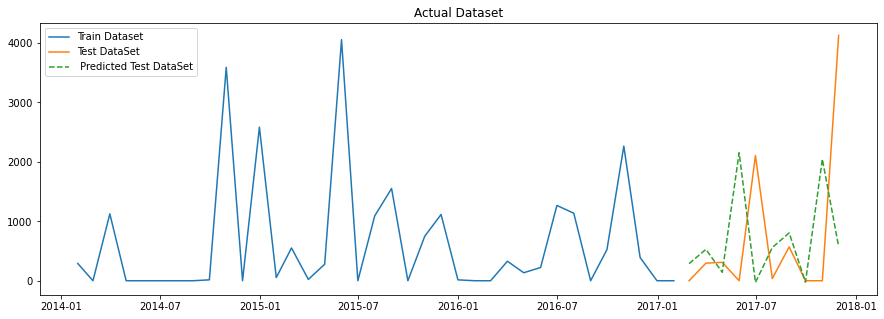

In [27]:
plt.figure(figsize=(15,5))
plt.plot(train.Sales,label= "Train Dataset")
plt.plot(test.Sales, label="Test DataSet")
plt.plot(df_predicted_test, "--",label=" Predicted Test DataSet")
plt.legend()
plt.title("Actual Dataset")
plt.show()

In [28]:
timeseries_evaluation_metrics(test.Sales, df_predicted_test)

Evaluation metric results:-
MSE is : 2652396.4429750196
MAE is : 1136.1846453849462
RMSE is : 1628.6179548853745
R2 is : -0.6122741685759308



<h6>SARIMA Model: Hyper tuning Auto Regression and Moving Average Component

In [29]:
p=list(range(0,5))
q=list(range(0,5))

P=list(range(0,5))
Q=list(range(0,5))


In [30]:
t=0
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                model = SARIMAX(df_fur_train,order=(i,0,j),seasonal_order=(k,0,l,12)).fit()
                score = model.aic
                if t==0:
                    min_score=score
                    p_min= i
                    q_min=j
                    P_min=k
                    Q_min=l
                    
                    t= t+1
                
                else:    
                    if score < min_score:
                        p_min= i
                        q_min=j
                        P_min=k
                        Q_min=l
                        
                    else:
                        
                        continue
print(f"p={p_min}\nq={q_min}\nP={P_min}\nQ={Q_min}")
print("AIC Score=",min_score)

p=1
q=1
P=1
Q=1
AIC Score= 632.0372217719076


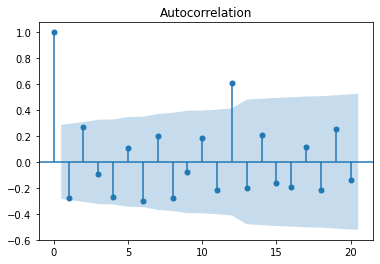

In [31]:
plot_acf(df_smooth,lags=20)
plt.show()

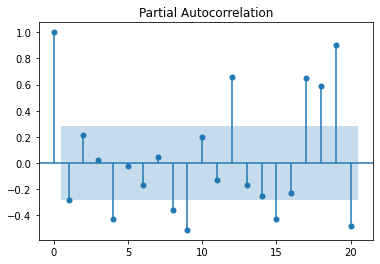

In [32]:
plot_pacf(df_smooth,lags=20,alpha=0.05)
plt.show()


From Auto correlation plot we got that q value = 1\
and from Partial Correlation Plot we got that p value = 1

In [33]:
model = SARIMAX(df_fur_train,order=(1,0,1),seasonal_order=(1,0,1,12)).fit()
pred= model.predict(start=len(df_fur_train), end=len(df_fur_train)+len(df_fur_test)-1)

In [34]:
pred

2017-02-28     499.614927
2017-03-31     277.581941
2017-04-30     323.557231
2017-05-31    2764.795567
2017-06-30     100.848558
2017-07-31     813.846797
2017-08-31    1108.245669
2017-09-30      89.701590
2017-10-31     977.020513
2017-11-30     833.447674
Freq: M, Name: predicted_mean, dtype: float64

In [35]:
df_fur_test

Order Date
2017-02-28     114.115288
2017-03-31     402.107837
2017-04-30     118.481684
2017-05-31    1106.729934
2017-06-30     647.674864
2017-07-31     853.190371
2017-08-31     355.534265
2017-09-30     252.736369
2017-10-31    2144.503799
2017-11-30     444.808809
Freq: M, dtype: float64

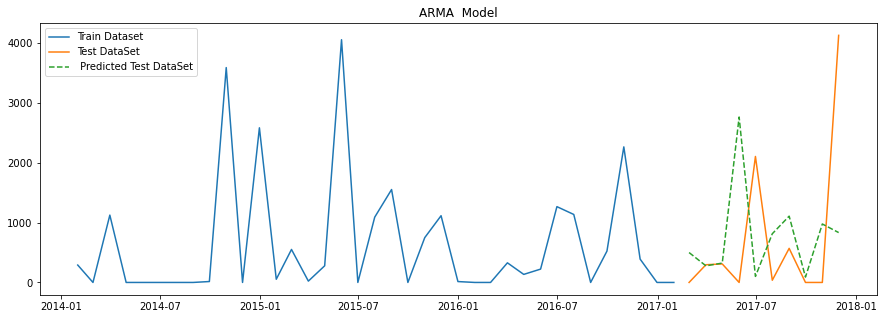

In [36]:
plt.figure(figsize=(15,5))
plt.plot(train.Sales,label= "Train Dataset")
plt.plot(test.Sales, label="Test DataSet")
plt.plot(pred, "--",label=" Predicted Test DataSet")
plt.legend()
plt.title("ARMA  Model")
plt.show()

In [37]:
timeseries_evaluation_metrics(df_fur_test, pred)

Evaluation metric results:-
MSE is : 536313.3407688227
MAE is : 543.1204929338817
RMSE is : 732.3341728806752
R2 is : -0.5770022309592302



In [38]:
df_fur_test=pd.DataFrame(df_fur_test)
test["Prediction"]= pred

In [39]:
print("Prediction on test set: ")
test.loc[:,["Sales","Prediction"]]

Prediction on test set: 


,Sales,Prediction
Order Date,,
2017-02-28,0.0000,499.614927
2017-03-31,296.1128,277.581941
2017-04-30,309.3440,323.557231
2017-05-31,0.0000,2764.795567
2017-06-30,2105.6610,100.848558
2017-07-31,36.9600,813.846797
2017-08-31,569.5680,1108.245669
2017-09-30,0.0000,89.701590
2017-10-31,0.0000,977.020513


In [40]:
pred100 =  model.predict(start=len(df_fur_new.Sales),end=len(df_fur_new.Sales)+52)

In [41]:
pred100 

2017-12-31     401.554605
2018-01-31     189.577224
2018-02-28     540.685951
2018-03-31     425.173704
2018-04-30     449.086792
2018-05-31    1719.082127
2018-06-30     333.218503
2018-07-31     704.135423
2018-08-31     857.285347
2018-09-30     327.405946
2018-10-31     789.009319
2018-11-30     714.314217
2018-12-31     489.626937
2019-01-31     379.345895
2019-02-28     561.997858
2019-03-31     501.900654
2019-04-30     514.336374
2019-05-31    1175.018627
2019-06-30     454.049416
2019-07-31     647.006150
2019-08-31     726.674456
2019-09-30     451.011971
2019-10-31     691.146313
2019-11-30     652.283319
2019-12-31     535.390236
2020-01-31     478.014450
2020-02-29     573.030535
2020-03-31     541.761773
2020-04-30     548.226650
2020-05-31     891.927345
2020-06-30     516.854642
2020-07-31     617.231556
2020-08-31     658.672687
2020-09-30     515.260890
2020-10-31     640.180903
2020-11-30     619.958766
2020-12-31     559.143214
2021-01-31     529.290210
2021-02-28  

AttributeError: 'DataFrame' object has no attribute 'Prediction'

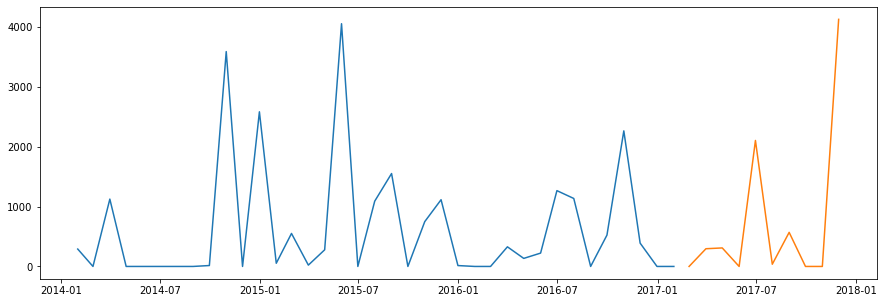

In [42]:
plt.figure(figsize=(15,5))
plt.plot(train.Sales,label= "Train Dataset")
plt.plot(test.Sales, label="Test DataSet")
plt.plot(df_fur_test.Prediction, label=" Predicted Test DataSet")
plt.plot(pred100,label=" Forecasted Sales for next year")

plt.legend()
plt.title("SARIMA Model")
plt.show()

In [ ]:
model.resid.plot(kind="kde")
plt.title("Distribution of Residual")
plt.show()

The Distribution of the Resudal is a normal Distribution which is stationary.

# Conclusion

1. We can see that in each year ending there is a spike in  sales of Furnitures. As the demand of Furniture is high in year end, store can increase the price of Furnitures in that time to amplify the Sales.
Also store can offer some discounts in the other months of a year so that sales gets increase in those months.<br>

2. Total Sale is high in Most of the Mondays. So store can increase the discounts in other days so that Total Sales gets Increased.<br>

3. Sales of Furniture is maximum in West Region<br>